In [1]:
import pandas as pd
from collections import Counter
import ast

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics 

import xgboost as xgb

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("nndb.csv")

In [3]:
df["IS_DECEASED"] = df["DIED"].notnull()

In [4]:
df.head()

,LINK,NAME,AKA,BORN,BIRTHPLACE,GENDER,RACE,OCCUPATION,NATIONALITY,EXECUTIVE_SUMMARY,DIED,LOCATION_OF_DEATH,CAUSE_OF_DEATH,AGE,RISK_FACTORS,IS_DECEASED
0,http://www.nndb.com/people/148/000163656/,Lyn Z,Lindsey Ann Ballato,1976-05-22,"Dunoon, Scotland",Female,White,NaN,United States,Bassist for Mindless Self Indulgence,NaN,NaN,NaN,47.0,NaN,False
1,http://www.nndb.com/people/013/000114668/,Morton Dauwen Zabel,NaN,1901-08-10,NaN,Male,White,NaN,United States,NaN,1964-04-28,,unspecified,63.0,NaN,True
2,http://www.nndb.com/people/076/000131680/,William Zabka,NaN,1965-10-20,NaN,Male,White,Actor,United States,Opponent of,NaN,NaN,NaN,58.0,NaN,False
3,http://www.nndb.com/people/146/000043017/,Grace Zabriskie,NaN,1941-05-17,NaN,Female,White,Actor,United States,Sarah Palmer in,NaN,NaN,NaN,82.0,"[\n ""Smoking""\n]",False
4,http://www.nndb.com/people/768/000127387/,John L. Zabriskie,NaN,1940-01-01,NaN,Male,White,Business,United States,"CEO of Pharmacia & Upjohn, 1995-97",NaN,NaN,NaN,83.0,NaN,False


In [5]:
data = df.RISK_FACTORS.to_list()

In [6]:
# Function to parse and clean individual strings
def parse_and_clean(s):
    # Check for NaN (float) values
    if isinstance(s, float):
        return []
    # Safely evaluate the string as a list
    parsed_list = ast.literal_eval(s)
    # Clean each element in the list
    return [item.strip() for item in parsed_list]

In [7]:
cleaned_data = [parse_and_clean(row) for row in data]

In [8]:
# Normalize the data: strip spaces and convert to lowercase
normalized_data = [[factor.strip().lower() for factor in sublist] for sublist in cleaned_data]

In [9]:
df2 = pd.DataFrame({'RISK_FACTORS': normalized_data})

In [10]:
# Flatten the list and get unique risk factors, normalized
unique_risk_factors = set(factor for sublist in normalized_data for factor in sublist)

In [11]:
# Create DataFrames for each risk factor and store them in a list
encoded_frames = []
for risk_factor in unique_risk_factors:
    # Create a column for each risk factor with 0s
    risk_factor_col = pd.Series([0] * len(df2))
    
    # Update the column with 1 where the risk factor is present
    for i, row in enumerate(df2['RISK_FACTORS']):
        if isinstance(row, list) and risk_factor in [item.lower().strip() for item in row]:
            risk_factor_col.at[i] = 1

    # Add the column to the list of DataFrames
    temp_df = pd.DataFrame({risk_factor: risk_factor_col})
    encoded_frames.append(temp_df)

In [12]:
# Concatenate all the encoded DataFrames
encoded_df = pd.concat(encoded_frames, axis=1)

# Join the encoded DataFrame with the original DataFrame
df = df.join(encoded_df)

In [13]:
df.obesity.value_counts()

obesity
0    39941
1      390
Name: count, dtype: int64

In [14]:
# Drop the original RISK_FACTORS column if necessary
df.drop('RISK_FACTORS', axis=1, inplace=True)

In [15]:
df['GENDER'] = df['GENDER'].astype("category")
df['RACE'] = df['RACE'].astype("category")
df['OCCUPATION'] = df['OCCUPATION'].astype("category")
df['NATIONALITY'] = df['NATIONALITY'].astype("category")
df['BIRTHPLACE'] = df['BIRTHPLACE'].astype("category")

In [16]:
# Convert the 'date_column' to datetime, coercing out-of-bounds dates to NaT
df['BORN'] = pd.to_datetime(df['BORN'], errors='coerce')
df['DIED'] = pd.to_datetime(df['DIED'], errors='coerce')

# Filter to keep only the rows where the date is >= 1700-01-01
df = df[df['BORN'] >= pd.Timestamp('1700-01-01')]

In [17]:
df_y = df['IS_DECEASED']
df_X = df.drop(columns=['IS_DECEASED', 'DIED', 'LOCATION_OF_DEATH', 'CAUSE_OF_DEATH', 'NAME', 'AKA', 'LINK', 'BORN', 'EXECUTIVE_SUMMARY'])

In [18]:
name_column = df['NAME']
age_column = df['AGE']
is_dead_column = df['IS_DECEASED']

In [19]:
# Split the data into 30% test and 70% training
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)

In [20]:
# count examples in each class
counter = Counter(df_y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 1.441


In [21]:
def create_pipe(clf):

    pipeline = Pipeline([('clf', clf)])

    return pipeline

In [22]:
clf = xgb.XGBClassifier(random_state=42, 
                        verbosity=0, 
                        tree_method="hist",
                        enable_categorical=True)

pipeline = create_pipe(clf)

In [23]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=True, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [24]:
feat_list = []
xgb_cols = pipeline['clf'].get_booster().feature_names
feat_imp = pipeline['clf'].feature_importances_

total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(xgb_cols, feat_imp):
    feat_list.append(feature)
    total_importance += feature[1]
        
# create DataFrame using data
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp['SUMMED_TOTAL'] = df_imp['IMPORTANCE'].cumsum()
df_imp.head(30)

,FEATURE,IMPORTANCE,SUMMED_TOTAL
3,OCCUPATION,0.063659,0.063659
1,GENDER,0.053137,0.116797
83,diabetes,0.046147,0.162944
106,alcoholism,0.044876,0.207820
107,parkinson's,0.031810,0.239630
131,malaria,0.028790,0.268420
68,vegetarian,0.027962,0.296382
4,NATIONALITY,0.027871,0.324253
123,tuberculosis,0.027181,0.351434
140,lung cancer,0.024164,0.375598


In [25]:
def print_confusion(pipeline):
    ''' take a supplied pipeline and run it against the train-test spit 
    and product scoring results.'''
    
    y_pred = pipeline.predict(X_test)

    print(metrics.classification_report(y_test, y_pred, digits=3))
        
    ConfusionMatrixDisplay.from_predictions(y_test, 
                                            y_pred, 
                                            cmap=plt.cm.Blues)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('02_confusion_matrix.png', dpi=300);

              precision    recall  f1-score   support

       False      0.745     0.799     0.771      6850
        True      0.667     0.594     0.628      4628

    accuracy                          0.717     11478
   macro avg      0.706     0.697     0.700     11478
weighted avg      0.713     0.717     0.714     11478



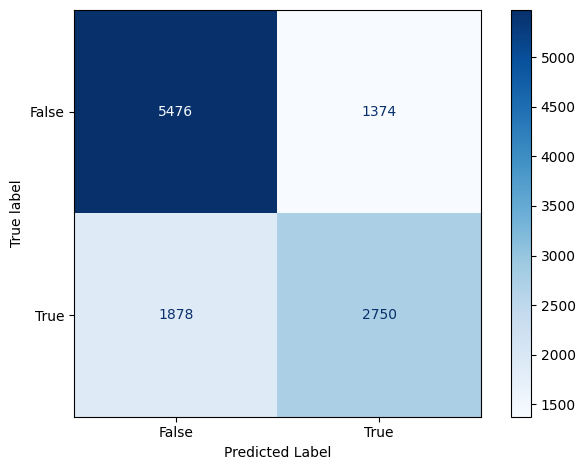

In [26]:
print_confusion(pipeline)

In [27]:
feat_list = []
xgb_cols = pipeline['clf'].get_booster().feature_names
feat_imp = pipeline['clf'].feature_importances_

total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(xgb_cols, feat_imp):
    feat_list.append(feature)
    total_importance += feature[1]
        
# create DataFrame using data
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp['SUMMED_TOTAL'] = df_imp['IMPORTANCE'].cumsum()
df_imp.head(30)

,FEATURE,IMPORTANCE,SUMMED_TOTAL
3,OCCUPATION,0.063659,0.063659
1,GENDER,0.053137,0.116797
83,diabetes,0.046147,0.162944
106,alcoholism,0.044876,0.207820
107,parkinson's,0.031810,0.239630
131,malaria,0.028790,0.268420
68,vegetarian,0.027962,0.296382
4,NATIONALITY,0.027871,0.324253
123,tuberculosis,0.027181,0.351434
140,lung cancer,0.024164,0.375598


In [28]:

# Predict the outcome variable based on the model
probs = pipeline.predict_proba(df_X)

# Get the Win probability for the `win` class
probs = probs[:,1]
probs = probs.round(3)

# Combine predictions with the name column
result_df = pd.DataFrame({
    'NAME': name_column,
    'AGE': age_column,
    'IS_DECEASED': is_dead_column,
    'PREDICTION': probs,
})

# Add the probability percentage to the DataFrame
# X['last_prediction_date'] = pd.Timestamp.today().strftime('%Y-%m-%d')
# X['convert_probability'] = probs.tolist()

In [29]:
result_df = result_df.sort_values('PREDICTION', ascending=False)
result_df

,NAME,AGE,IS_DECEASED,PREDICTION
22769,Ansel Adams,82.0,True,1.000
577,George Washington,67.0,True,1.000
37339,Jules Laforgue,27.0,True,1.000
12953,Guy de Maupassant,43.0,True,1.000
32377,Lord Byron,36.0,True,1.000
...,...,...,...,...
1363,Naomi Watts,55.0,False,0.001
30034,Drew Barrymore,48.0,False,0.001
5176,Gwyneth Paltrow,51.0,False,0.001
39826,Milla Jovovich,48.0,False,0.000


In [30]:
filtered_df = result_df[result_df['IS_DECEASED'] == False]
filtered_df

,NAME,AGE,IS_DECEASED,PREDICTION
28674,Ginger Baker,84.0,False,0.990
33859,Dick Cheney,82.0,False,0.989
1574,David Wells,60.0,False,0.984
17674,Mikhail Gorbachev,92.0,False,0.973
23865,Lance Armstrong,52.0,False,0.972
...,...,...,...,...
1363,Naomi Watts,55.0,False,0.001
30034,Drew Barrymore,48.0,False,0.001
5176,Gwyneth Paltrow,51.0,False,0.001
39826,Milla Jovovich,48.0,False,0.000


In [31]:
df_leads = filtered_df[filtered_df['PREDICTION'] >= 0.75]
df_leads

,NAME,AGE,IS_DECEASED,PREDICTION
28674,Ginger Baker,84.0,False,0.990
33859,Dick Cheney,82.0,False,0.989
1574,David Wells,60.0,False,0.984
17674,Mikhail Gorbachev,92.0,False,0.973
23865,Lance Armstrong,52.0,False,0.972
...,...,...,...,...
1217,Florence Welch,37.0,False,0.750
29240,Roberto Benigni,71.0,False,0.750
22999,George A. Akerlof,83.0,False,0.750
30412,Nuno Bettencourt,57.0,False,0.750


In [32]:
df_leads.to_csv('dead_pool_leads.csv', index=False)
